In [45]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import seaborn as sns

In [2]:
csv = pd.read_csv('pistachios.csv', index_col = 0)

In [3]:
csv.pistachio_type.value_counts()

0    1232
1     916
Name: pistachio_type, dtype: int64

In [4]:
#Create list of random indexes to display random images
random.seed(123)
random_image_index = np.random.randint(csv.shape[0], size=10)

In [5]:
images = []
for name in csv.filename:
    images.append(plt.imread('Pistachio_Image_Dataset\Pistachio_Image_Dataset\\' + name))

In [6]:
grey_images = []
for img in images:
    grey_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

In [7]:
percent_area = []
for img in grey_images:
    percent_area.append(np.count_nonzero(img)/(img.shape[0]*img.shape[1]))

In [8]:
csv['percent_area'] = percent_area

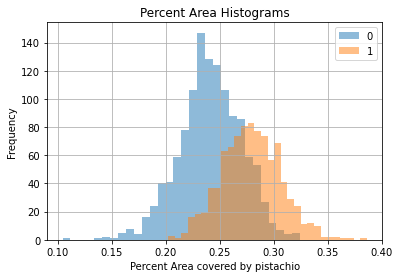

In [9]:
plt.hist(csv[csv.pistachio_type == 0].percent_area, bins = 30, alpha = 0.5, label = 0)
plt.hist(csv[csv.pistachio_type == 1].percent_area, bins = 30, alpha = 0.5, label = 1)
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('Percent Area covered by pistachio')
plt.ylabel('Frequency')
plt.title('Percent Area Histograms')
plt.show()

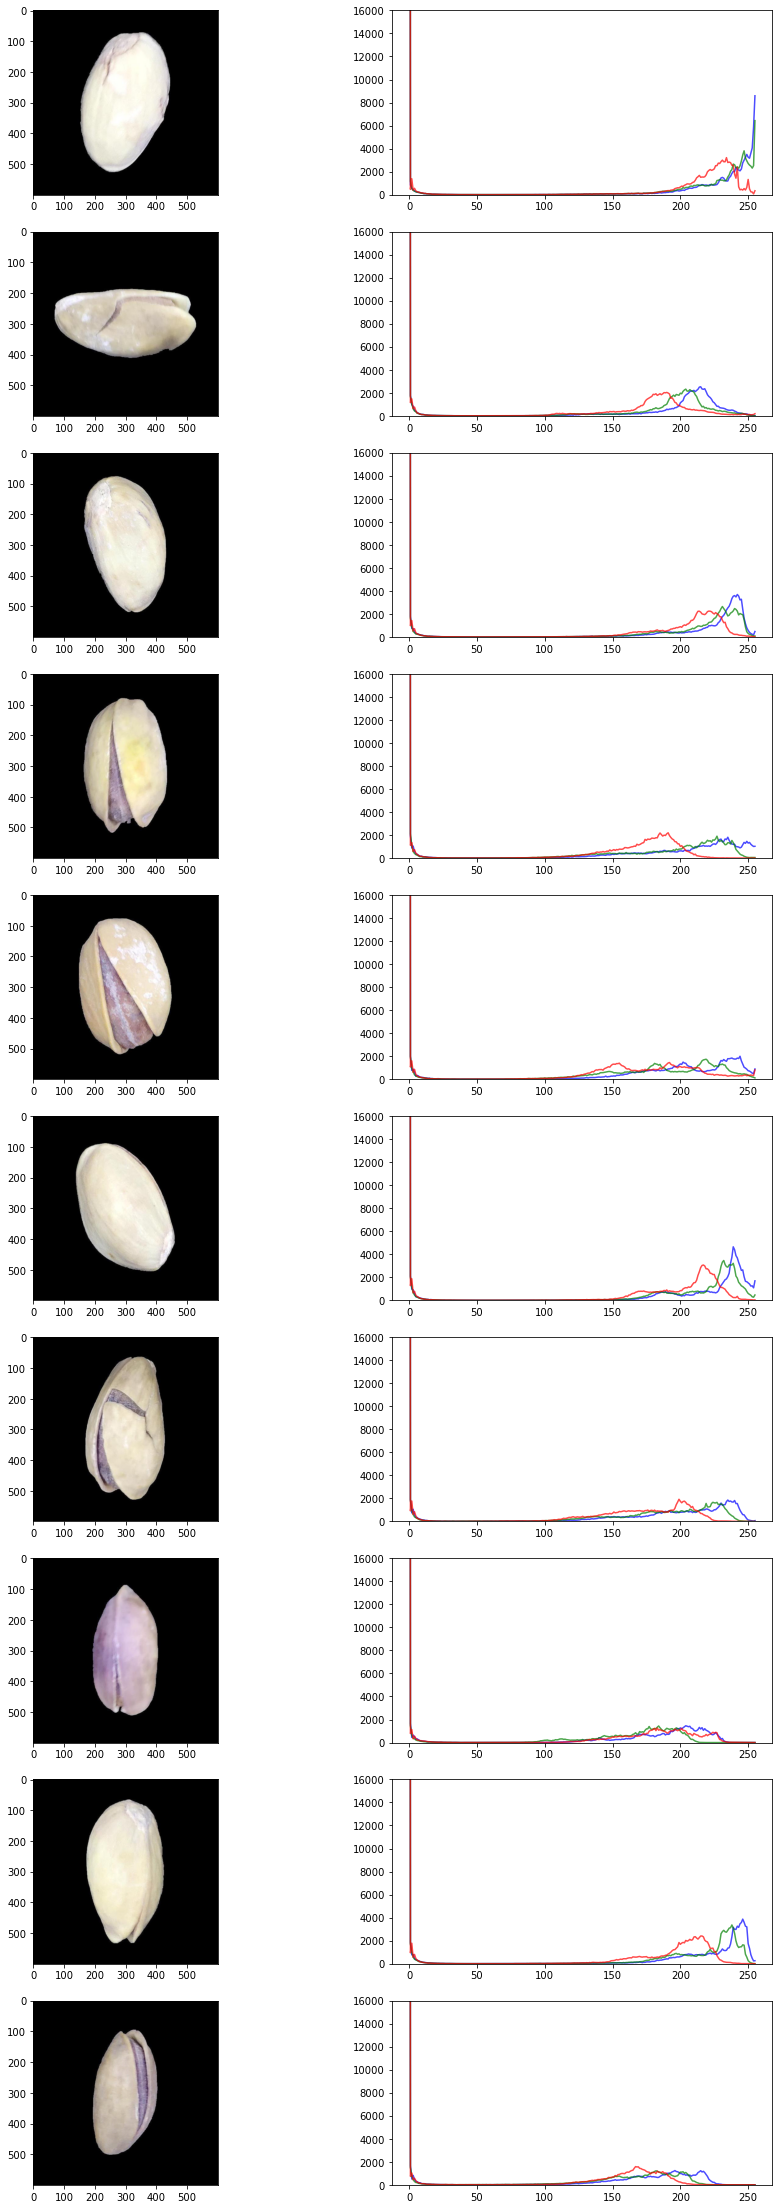

In [10]:
color_hist_images = [images[i] for i in random_image_index]
fig, ax = plt.subplots(len(random_image_index),2, figsize = (15, 40))


for j, img in enumerate(color_hist_images):
    
    ax[j,0].imshow(img)
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        ax[j,1].plot(histr,color = col, alpha = 0.7)
        ax[j,1].set_ylim([0, 16000])
plt.show()

In [11]:
#Rescale and blur
rescaled_images = []
for img in grey_images:
    rescaled_images.append(cv2.GaussianBlur(cv2.resize(img, (200, 200)), (9, 9), 0))

In [12]:
def fit_ellipse(img):
        
    out_img = img.copy()            
    
    try:
        
        ret,thresh = cv2.threshold(out_img,5,255,0)
        contours,hierarchy = cv2.findContours(thresh, 1, 2)
        
        cnt = contours[-1]
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt,True)
        ellipse = cv2.fitEllipse(cnt)
        return cv2.ellipse(out_img,ellipse,(255),2), cv2.ellipse(np.zeros_like(out_img),ellipse,(255),1), ellipse

    except cv2.error as e:
        pass

ellipse_images = []
for img in rescaled_images:
    ellipse_images.append(fit_ellipse(img))

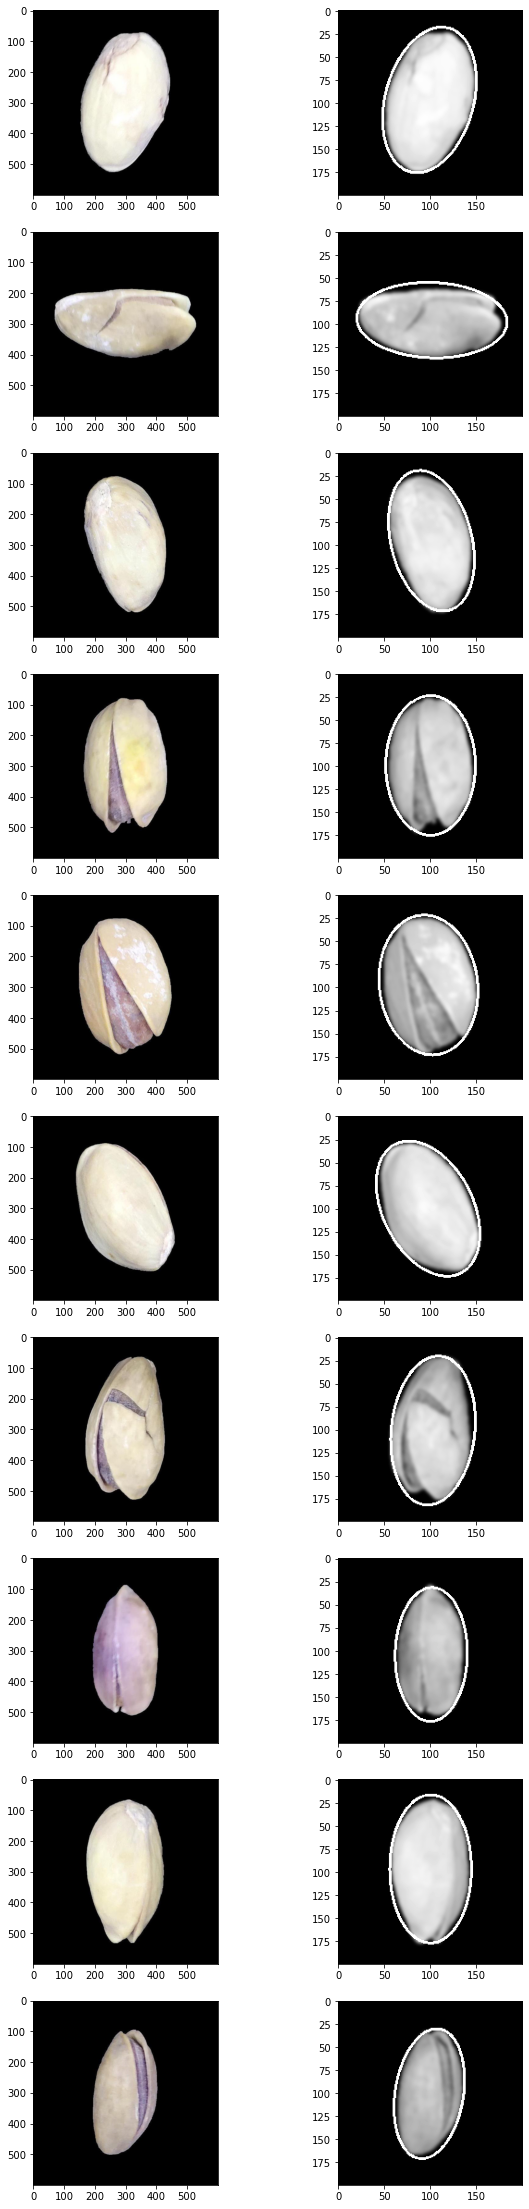

In [13]:
fig, ax = plt.subplots(len(random_image_index),2, figsize = (10, 40))

for j, index in enumerate(random_image_index):
    
    try:
        ax[j,0].imshow(images[index])
        ax[j,1].imshow(ellipse_images[index][0], cmap = 'gray')
        
    except:
        pass
        

In [14]:
def whiten_image(img):
    '''Take a full resolution image of pistachio, blow up pistachio to white,
    and rescale to 200,200 and blur.
    '''    
    out_img = img.copy()
    
    out_img = np.where(out_img > 5, 255, 0).astype('uint8')
    
    return cv2.Canny(out_img, 100, 200)

white_patch_edge_detect = []
for img in rescaled_images:
    white_patch_edge_detect.append(whiten_image(img))

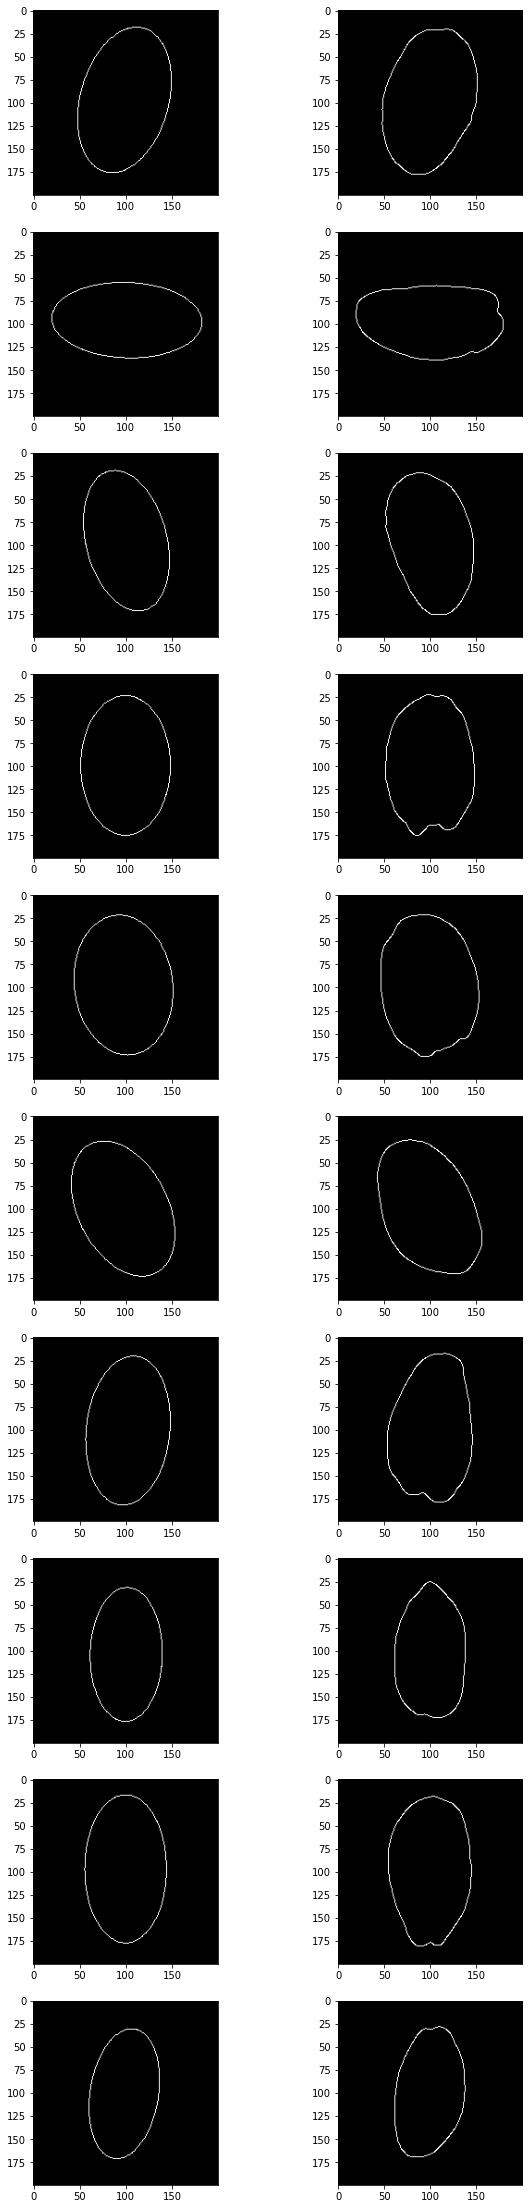

In [15]:
fig, ax = plt.subplots(len(random_image_index),2, figsize = (10, 40))

for j, index in enumerate(random_image_index):
    
    try:
        ax[j,0].imshow(ellipse_images[index][1], cmap = 'gray')
        ax[j,1].imshow(white_patch_edge_detect[index], cmap = 'gray')
        
    except:
        pass
        

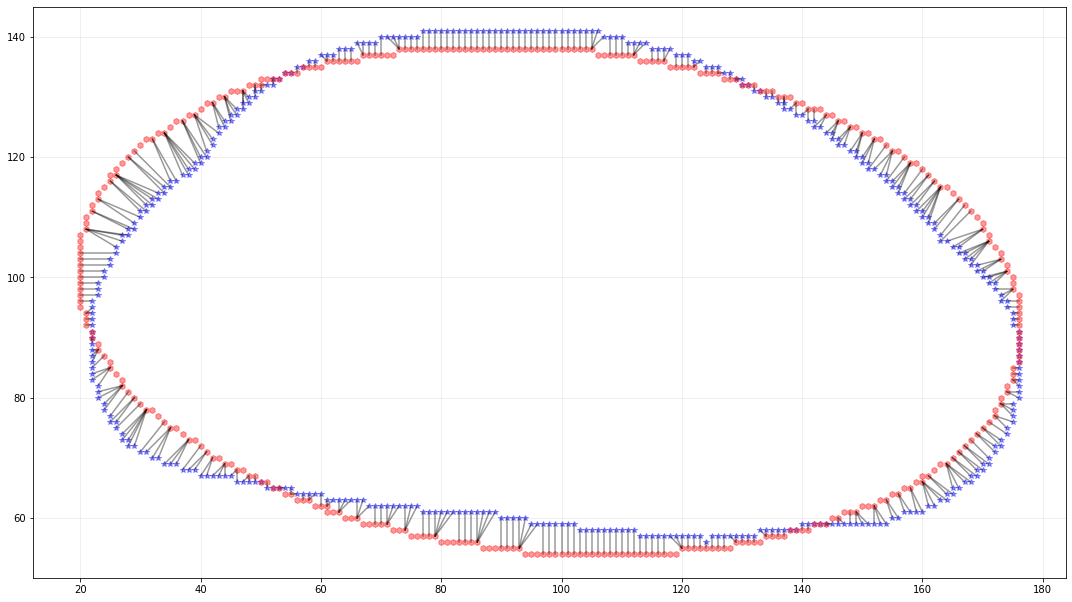

In [16]:
import numpy as np
from scipy.cluster.vq import vq
import matplotlib.pyplot as plt


# `points1` is the set A described in the question.
points1 = np.argwhere(white_patch_edge_detect[124] == 255)

# `points2` is the set B.  In this example, there are 5 points in B.
points2 = np.argwhere(ellipse_images[124][1] == 255)

# For each point in points1, find the closest point in points2:
code, dist = vq(points1, points2)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot(points1[:,0], points1[:,1], 'b*', markersize=6, alpha=0.4)
plt.plot(points2[:,0], points2[:,1], 'rh', markersize=6, alpha=0.4)

for i, j in enumerate(code):
    plt.plot([points1[i,0], points2[j,0]],
             [points1[i,1], points2[j,1]], 'k', alpha=0.4)

plt.grid(True, alpha=0.25)
plt.axis('equal')
plt.show()

In [17]:
ellipse_images[645][2]

((98.6805191040039, 100.3239517211914),
 (89.16055297851562, 165.06576538085938),
 3.3431026935577393)

In [18]:
def calculate_distance(ellipse_img, edge_img):
    '''This function calcualtes the minimum distance between points on 
    the edge image and points on the ellipse image. Returns total disstance normalized by ellipse perimeter
    '''
    edge_points = np.argwhere(edge_img == 255)
    ellipse_points = np.argwhere(ellipse_img[1] == 255)
    
       
    code, dist = vq(edge_points, ellipse_points)
    
    return dist.sum()/calculate_perimeter(ellipse_img[2][1][0], ellipse_img[2][1][1])
    
def calculate_perimeter(a,b):
    perimeter = np.pi * ( 3*(a+b) - np.sqrt( (3*a + b) * (a + 3*b) ) )
    return perimeter

In [19]:
distance_from_ellipse = []
for i in range(len(images)):
    try:
        distance_from_ellipse.append(calculate_distance(ellipse_images[i], white_patch_edge_detect[i]))
    except:
        print(i)
        distance_from_ellipse.append(np.nan)

In [20]:
csv['distance_from_ellipse'] = distance_from_ellipse

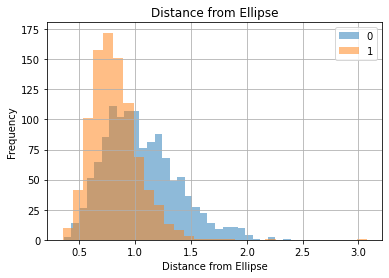

In [21]:
plt.hist(csv[csv.pistachio_type == 0].distance_from_ellipse, bins = 30, alpha = 0.5, label = 0)
plt.hist(csv[csv.pistachio_type == 1].distance_from_ellipse, bins = 30, alpha = 0.5, label = 1)
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('Distance from Ellipse')
plt.ylabel('Frequency')
plt.title('Distance from Ellipse')
plt.show()

In [49]:
#Rescale Colored images and convert to HSV
rescaled_images_color = []
for img in images:
    rescaled_images_color.append(cv2.cvtColor(cv2.GaussianBlur(cv2.resize(img, (200, 200)), (9,9), 0)
                                              ,cv2.COLOR_BGR2HSV))

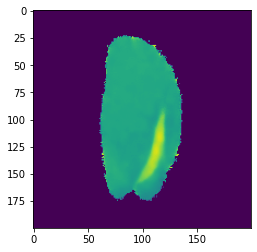

In [74]:
plt.imshow(rescaled_images_color[456][:,:,0])

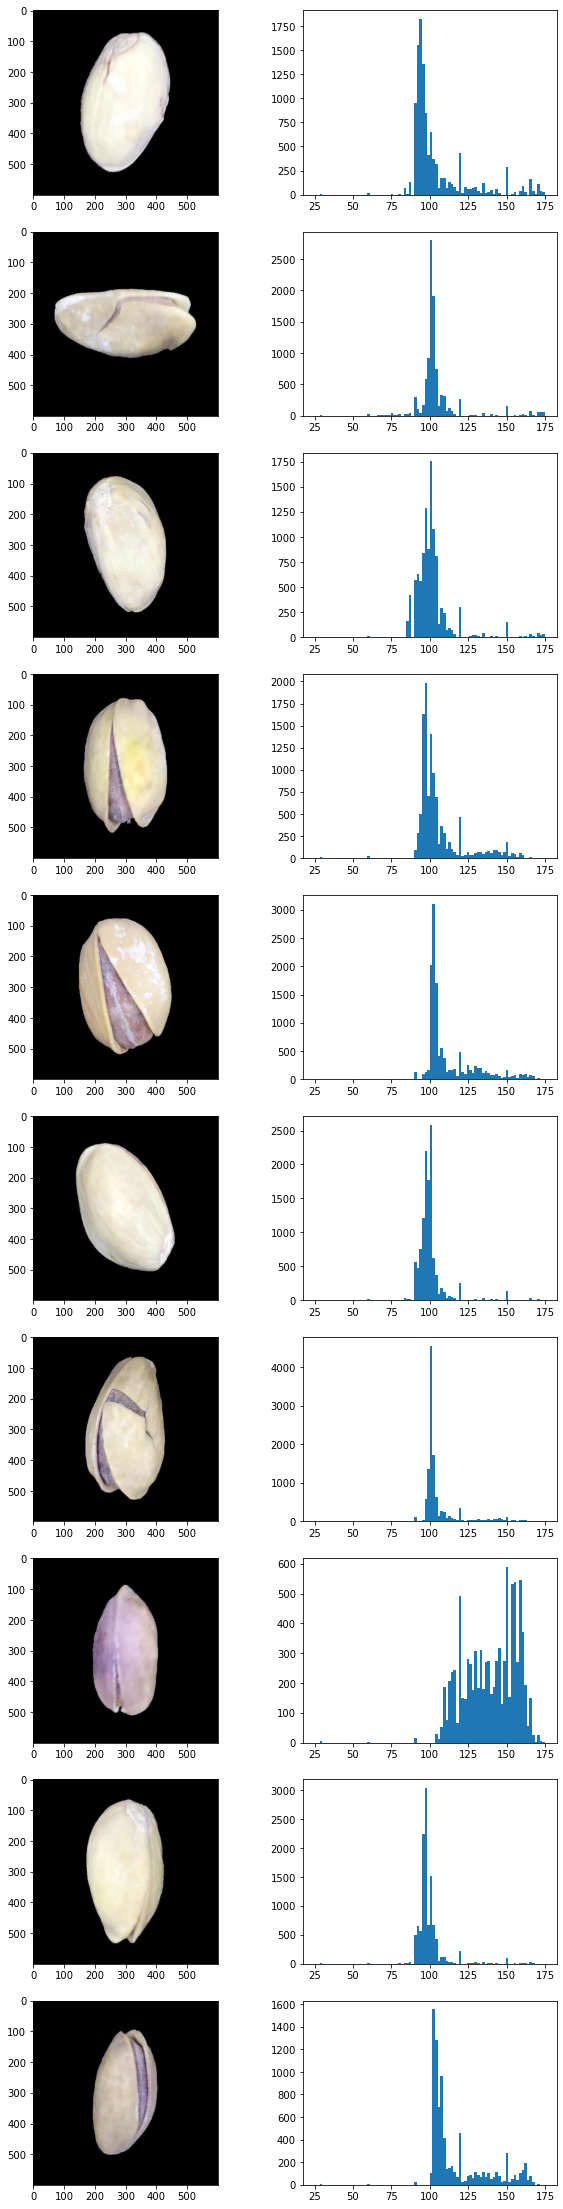

In [62]:
fig, ax = plt.subplots(len(random_image_index),2, figsize = (10, 40))

for j, index in enumerate(random_image_index):
    
    try:
        ax[j,0].imshow(images[index])
        ax[j,1].hist(rescaled_images_color[index][:,:,0].flatten(), bins = 88, range = (25, 175))
        
    except:
        pass
        

In [66]:
np.average(rescaled_images_color[456][:,:,0], weights=(rescaled_images_color[456][:,:,0]>25))

101.10471895281047

In [68]:
average_hue = []
for i in range(len(images)):
    try:
        average_hue.append(np.average(rescaled_images_color[i][:,:,0], 
                                      weights=(rescaled_images_color[i][:,:,0]>25)))
    except:
        print(i)
        average_hue.append(np.nan)


In [72]:
csv['average_hue'] = average_hue

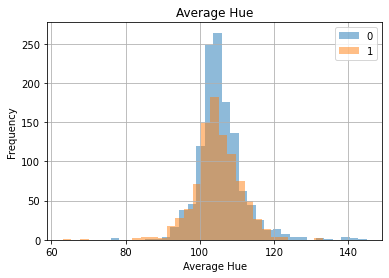

In [73]:
plt.hist(csv[csv.pistachio_type == 0].average_hue, bins = 30, alpha = 0.5, label = 0)
plt.hist(csv[csv.pistachio_type == 1].average_hue, bins = 30, alpha = 0.5, label = 1)
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('Average Hue')
plt.ylabel('Frequency')
plt.title('Average Hue')
plt.show()